## Pre Processing to Create Masks


In [ ]:
import os
import numpy as np
import cv2
import pandas as pd

# Function to create mask image
def create_mask(answer_grounding, img_height, img_width):
    # Create a blank mask
    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    # Convert answer_grounding to numpy array of points
    points = np.array([(int(point['x']), int(point['y'])) for point in answer_grounding], dtype=np.int32)
    # Fill the polygon defined by points
    cv2.fillPoly(mask, [points], color=255)
    return mask

mask_dir = 'mask/train'
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

# Iterate over each row in the DataFrame
for index, row in train_df_trans.iterrows():
    # Extract necessary information from the row
    answer_grounding = row['answer_grounding']
    img_height = row['height']
    img_width = row['width']
    
    image_path = '/images/train/' + index
    print(image_path) 
    
    # Create the mask for the current row
    mask = create_mask(answer_grounding, img_height, img_width)
    
    # Save the mask image
    mask_filename = os.path.splitext(os.path.basename(image_path))[0] + '_mask.jpg'
    mask_path = os.path.join(mask_dir, mask_filename)
    cv2.imwrite(mask_path, mask)


mask_dir = 'mask/val'
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

# Iterate over each row in the DataFrame
for index, row in val_df_trans.iterrows():
    # Extract necessary information from the row
    answer_grounding = row['answer_grounding']
    img_height = row['height']
    img_width = row['width']
    
    image_path = '/images/val/' + index
    print(image_path) 
    
    # Create the mask for the current row
    mask = create_mask(answer_grounding, img_height, img_width)
    
    # Save the mask image
    mask_filename = os.path.splitext(os.path.basename(image_path))[0] + '_mask.jpg'
    mask_path = os.path.join(mask_dir, mask_filename)
    cv2.imwrite(mask_path, mask)




## Train Model

In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms as T

class CustDat(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self, idx):
        img_path = "./images/train/" + self.imgs[idx]
        mask_path = "./mask/train/" + self.masks[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Filter to include only mask 255
        masks = mask == 255

        # Find bounding boxes from masks
        pos = np.where(masks)
        if pos[0].size > 0 and pos[1].size > 0:
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes = [xmin, ymin, xmax, ymax]
            boxes = torch.as_tensor([boxes], dtype=torch.float32)  # Convert to tensor and add extra dimension for batch
            labels = torch.tensor([1], dtype=torch.int64)  # Assuming label 1 for the object
            masks = torch.as_tensor(masks, dtype=torch.uint8).unsqueeze(0)  # Add dimension for batch
        else:
            print('x')
            # Handle case with no mask found
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            masks = torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.imgs)

/nfs/home/lie3061/.conda/envs/xiyi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

transform = T.ToTensor()
def custom_collate(data):
  return data

images = sorted(os.listdir("./images/train"))
masks = sorted(os.listdir("./mask/train"))
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]



train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) , 
                                 batch_size = 2 , 
                                 shuffle = True , 
                                 collate_fn = custom_collate , 
                                 num_workers = 0 , 
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) , 
                                 batch_size = 2 , 
                                 shuffle = True , 
                                 collate_fn = custom_collate , 
                                 num_workers = 0 , 
                                 pin_memory = True if torch.cuda.is_available() else False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(30):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    ]
            print(epoch, "  ", train_epoch_loss, "  ")
    all_train_losses.append(train_epoch_loss)

    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)

    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss

## Sample Eval

In [3]:
import torchvision
import os
import torch 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn()

def get_model(num_classes):
    # Load a pre-trained model for transfer learning
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # And replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Initialize the model with 2 classes (1 class + background)
model = get_model(2)  # Adjust this to match your specific needs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the model
model_path = './RCNN/model_checkpoint_epoch_49.pth'
model.load_state_dict(torch.load(model_path))        
model.eval()


In [8]:
import os

# Select three sample image filenames
image_filenames = [
    'VizWiz_train_00000128.jpg',
    'VizWiz_train_00000570.jpg',
    'VizWiz_train_00003562.jpg',
]

# Create a list to store the corresponding mask filenames
mask_filenames = []

# Get the corresponding mask filenames
for filename in image_filenames:
    mask_filename = os.path.join(os.path.splitext(filename)[0] + "_mask.jpg")
    mask_filenames.append(mask_filename)

# Create a dataset with the selected image and mask filenames
test_dataset = CustDat(image_filenames, mask_filenames)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


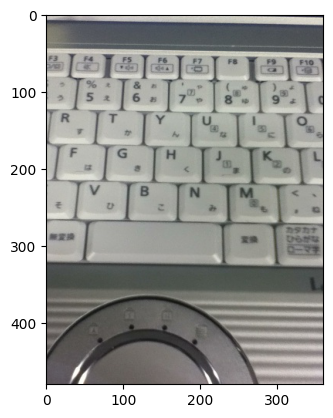

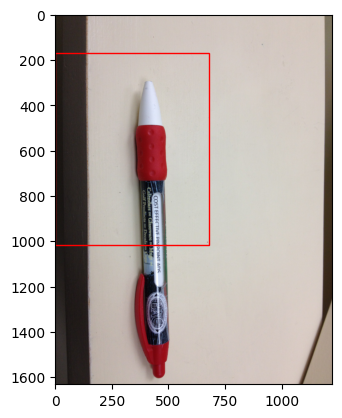

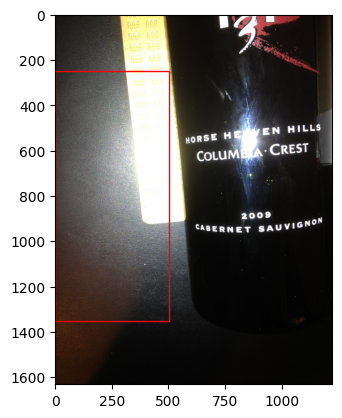

In [9]:
from torchvision.transforms.functional import to_pil_image

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T

for i in range(len(test_dataset)):
    sample_image, sample_target = test_dataset[i]
    predicted_output = model([sample_image.to(device)])

    # Visualization
    predicted_boxes = predicted_output[0]['boxes'].cpu().data.numpy()
    scores = predicted_output[0]['scores'].cpu().data.numpy()
    high_score_index = scores.argmax()  # Index of the highest score

    fig, ax = plt.subplots(1)
    ax.imshow(to_pil_image(sample_image))
    box = predicted_boxes[high_score_index]
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.show()